# Train the SupCon version

In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
from simple_model.model import SimCLR, train_simclr
from simple_model.dataloader import PairedContrastiveDataset, make_sampler

In [2]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
os.environ['TENSORBOARD_BINARY'] = '/p/project1/hai_fzj_bda/koenig8/jupyter/kernels/contrastive_learn/bin/tensorboard'

import pytorch_lightning as pl
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

import scanpy as sc
from pytorch_lightning.callbacks import TQDMProgressBar
import pandas as pd
from plotnine import *

In [3]:
path = "/p/project1/hai_fzj_bda/koenig8/ot/data/"
adata_st = sc.read_h5ad(os.path.join(path, "adata_st.h5ad"))
adata_histo = sc.read_h5ad(os.path.join(path, "adata_histo.h5ad"))
adata_st, adata_histo

(AnnData object with n_obs × n_vars = 50000 × 50
     obs: 'patch_id', 'brain_area', 'patchsize', 'x_st', 'y_st', 'z_st', 'brain_section_label', 'section', 'test_set', 'val_set', 'train_set'
     uns: 'neighbors', 'umap'
     obsm: 'X_umap', 'brain_area_onehot', 'brain_area_similarities', 'pca_embedding', 'pca_plus_slides', 'pca_plus_slides_scaled'
     obsp: 'connectivities', 'distances',
 AnnData object with n_obs × n_vars = 190659 × 1536
     obs: 'image_id', 'patchsize', 'center_ccf', 'pixel_coord', 'distance', 'nearest_ST', 'nearest_cell_id', 'target_atlas_plate', 'distance_new', 'x', 'y', 'z', 'x_st', 'y_st', 'z_st', 'image_nr', 'brain_area', 'group', 'slice', 'in_sample', 'test_set', 'val_set', 'train_set'
     obsm: 'brain_area_onehot', 'brain_area_similarities', 'uni_embedding', 'uni_pca_95', 'uni_pca_plus_coords')

In [4]:
train_set = make_sampler(
    adata_st, adata_histo, 10, 150, oversample_fraction=0.3, st_key = "pca_embedding", histo_key = "uni_pca_95", 
    class_key = "brain_area_onehot", mode = "train", seed = 42
)
val_set = make_sampler(
    adata_st, adata_histo, 5, 100, oversample_fraction=0.3, st_key = "pca_embedding", histo_key = "uni_pca_95", 
    class_key = "brain_area_onehot", mode = "val", seed = 42
)

ST shape: (36832, 50), Histo shape: (96517, 368)
samples lost from class rebalancing: 9
ST shape: (7665, 50), Histo shape: (36112, 368)
samples lost from class rebalancing: 10


## Plot some statistics about the validation loader

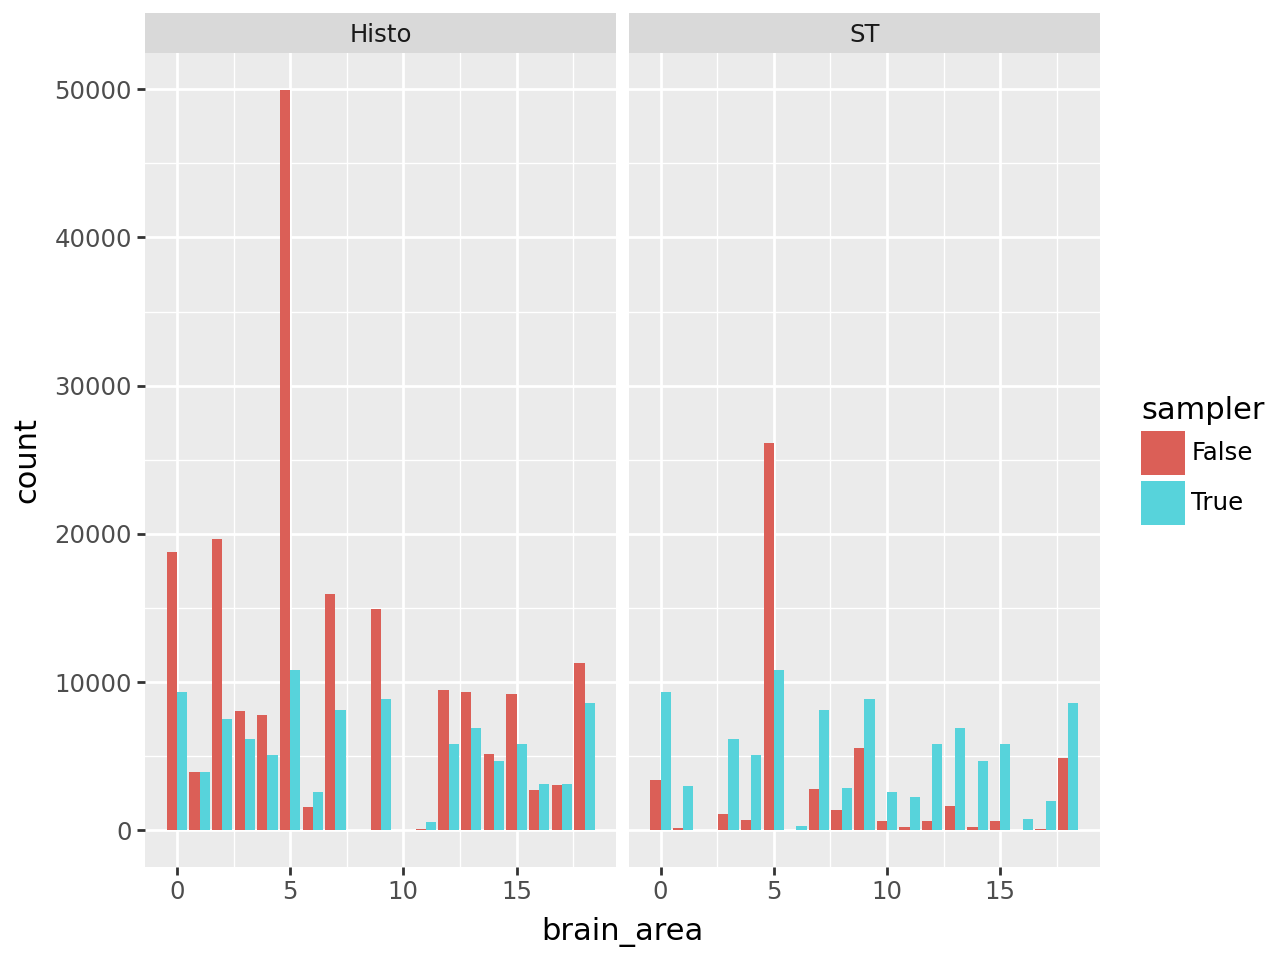

In [5]:
st_labels, histo_labels = [], []

for batch in train_set:
    st_labels_ = batch["a_classes"] 
    histo_labels_ = batch["b_classes"] 
    st_labels.append(st_labels_.numpy())
    histo_labels.append(histo_labels_.numpy())

df_sampler = pd.DataFrame(dict(
    brain_area = np.hstack(st_labels + histo_labels),
    modality = ["ST"] * len(np.hstack(st_labels)) + ["Histo"] * len(np.hstack(histo_labels))
))
df_st = pd.DataFrame(dict(
    brain_area = adata_st.obsm["brain_area_onehot"].toarray().nonzero()[-1],
    modality = ["ST"] * len(adata_st)
))
df_histo = pd.DataFrame(dict(
    brain_area = adata_histo.obsm["brain_area_onehot"].toarray().nonzero()[-1],
    modality = ["Histo"] * len(adata_histo)
))
df_plot = pd.concat(
    (df_sampler.assign(sampler = True), df_st.assign(sampler=False), df_histo.assign(sampler=False))
)
df_plot["brain_area"] = df_plot["brain_area"].astype(int)

ggplot(df_plot, aes(x="brain_area", fill="sampler")) + geom_bar(position="dodge") + facet_wrap("modality")

==> represents classes very well

## Look at the number of instances per class per batch

In [24]:
st_counts = [[] for _ in range(np.max(df_plot["brain_area"]) + 1)]
histo_counts = [[] for _ in range(np.max(df_plot["brain_area"]) + 1)]
for batch in st_labels:
    classes, freqs = np.unique(batch, return_counts=True)
    for i in range(len(classes)):
        st_counts[classes[i]].append(freqs[i])
for batch in histo_labels:
    classes, freqs = np.unique(batch, return_counts=True)
    for i in range(len(classes)):
        histo_counts[classes[i]].append(freqs[i])

st_frame = pd.DataFrame(dict())

[[np.int64(100),
  np.int64(100),
  np.int64(100),
  np.int64(100),
  np.int64(100),
  np.int64(100),
  np.int64(100),
  np.int64(100),
  np.int64(100),
  np.int64(100),
  np.int64(100),
  np.int64(100),
  np.int64(100),
  np.int64(100),
  np.int64(100),
  np.int64(100),
  np.int64(100),
  np.int64(100),
  np.int64(100),
  np.int64(100),
  np.int64(100),
  np.int64(100),
  np.int64(100),
  np.int64(100),
  np.int64(100),
  np.int64(100),
  np.int64(100),
  np.int64(100),
  np.int64(100),
  np.int64(100),
  np.int64(100),
  np.int64(100),
  np.int64(100),
  np.int64(100),
  np.int64(100)],
 [np.int64(13),
  np.int64(13),
  np.int64(13),
  np.int64(13),
  np.int64(13),
  np.int64(13),
  np.int64(13),
  np.int64(13),
  np.int64(13),
  np.int64(13)],
 [],
 [np.int64(76),
  np.int64(76),
  np.int64(76),
  np.int64(76),
  np.int64(76),
  np.int64(76),
  np.int64(76),
  np.int64(76),
  np.int64(76),
  np.int64(76),
  np.int64(76),
  np.int64(76),
  np.int64(76),
  np.int64(76)],
 [np.int64(75

In [18]:
workdir = "/p/project1/hai_fzj_bda/koenig8/cl/supcon"
logger = pl.loggers.TensorBoardLogger(
    os.path.join(workdir, "logs"), name="SupCon"
)
monitor_mode = "min"

model = train_simclr(
    train_set, val_set, os.path.join(workdir, "simclr_ckpt"), limit_train_batches = None, logger = logger, 
    refresh_rate = 1000, monitor = "val_loss", monitor_mode = monitor_mode, dropout = 0.3,
    hidden_dims=[1024, 128], latent_dim = 64, patience=10,
    lr=5e-4, temperature=0.07, weight_decay=1e-6,
    use_batchnorm = True, log_every = 1000, shuffle_every = 1, max_epochs = 20, projection_head=True
)

print ("Finished training SimCLR")

[rank: 0] Global seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3     ]

  | Name        | Type        | Params
--------------------------------------------
0 | histo_model | SimpleModel | 519 K 
1 | st_model    | SimpleModel | 193 K 
--------------------------------------------
713 K     Trainable params
0         Non-trainable params
713 K     Total params
2.854     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


NUM_WORKERS: 1
Epoch 0: : 0it [00:00, ?it/s]                                              
idation: 0it [00:00, ?it/s]
idation: 0it [00:00, ?it/s]
Epoch 0: : 0it [00:02, ?it/s, loss=6.23, v_num=7, train_loss_step=6.160, val_loss=5.220]
                                          

Metric val_loss improved. New best score: 5.220


Shuffled datat [00:00, ?it/s, loss=6.23, v_num=7, train_loss_step=6.160, val_loss=5.220, train_loss_epoch=6.730]

idation: 0it [00:00, ?it/s]
idation: 0it [00:00, ?it/s]
Epoch 1: : 0it [00:03, ?it/s, loss=6.09, v_num=7, train_loss_step=6.100, val_loss=5.170, train_loss_epoch=6.730]
                                          

Metric val_loss improved by 0.048 >= min_delta = 0.0. New best score: 5.171


Shuffled datat [00:00, ?it/s, loss=6.09, v_num=7, train_loss_step=6.100, val_loss=5.170, train_loss_epoch=6.140]

idation: 0it [00:00, ?it/s]
idation: 0it [00:00, ?it/s]
Epoch 2: : 0it [00:02, ?it/s, loss=6, v_num=7, train_loss_step=5.950, val_loss=5.160, train_loss_epoch=6.140]   
                                          

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 5.163


Shuffled datat [00:00, ?it/s, loss=6, v_num=7, train_loss_step=5.950, val_loss=5.160, train_loss_epoch=6.020]

idation: 0it [00:00, ?it/s]
idation: 0it [00:00, ?it/s]
Epoch 3: : 0it [00:02, ?it/s, loss=5.95, v_num=7, train_loss_step=5.900, val_loss=5.160, train_loss_epoch=6.020]
                                          

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 5.157


Shuffled datat [00:00, ?it/s, loss=5.95, v_num=7, train_loss_step=5.900, val_loss=5.160, train_loss_epoch=5.970]

idation: 0it [00:00, ?it/s]
idation: 0it [00:00, ?it/s]
Epoch 4: : 0it [00:02, ?it/s, loss=5.89, v_num=7, train_loss_step=5.890, val_loss=5.170, train_loss_epoch=5.970]
Shuffled datat [00:00, ?it/s, loss=5.89, v_num=7, train_loss_step=5.890, val_loss=5.170, train_loss_epoch=5.920]

idation: 0it [00:00, ?it/s]
idation: 0it [00:00, ?it/s]
Epoch 5: : 0it [00:02, ?it/s, loss=5.83, v_num=7, train_loss_step=5.860, val_loss=5.170, train_loss_epoch=5.920]
Shuffled datat [00:00, ?it/s, loss=5.83, v_num=7, train_loss_step=5.860, val_loss=5.170, train_loss_epoch=5.870]

idation: 0it [00:00, ?it/s]
idation: 0it [00:00, ?it/s]
Epoch 6: : 0it [00:02, ?it/s, loss=5.81, v_num=7, train_loss_step=5.900, val_loss=5.190, train_loss_epoch=5.870]
Shuffled datat [00:00, ?it/s, loss=5.81, v_num=7, train_loss_step=5.900, val_loss=5.190, train_loss_epoch=5.840]

idation: 0it [00:00, ?it/s]
idation: 

Monitored metric val_loss did not improve in the last 10 records. Best score: 5.157. Signaling Trainer to stop.


Epoch 13: : 0it [00:03, ?it/s, loss=5.71, v_num=7, train_loss_step=5.740, val_loss=5.240, train_loss_epoch=5.710]
Finished training SimCLR


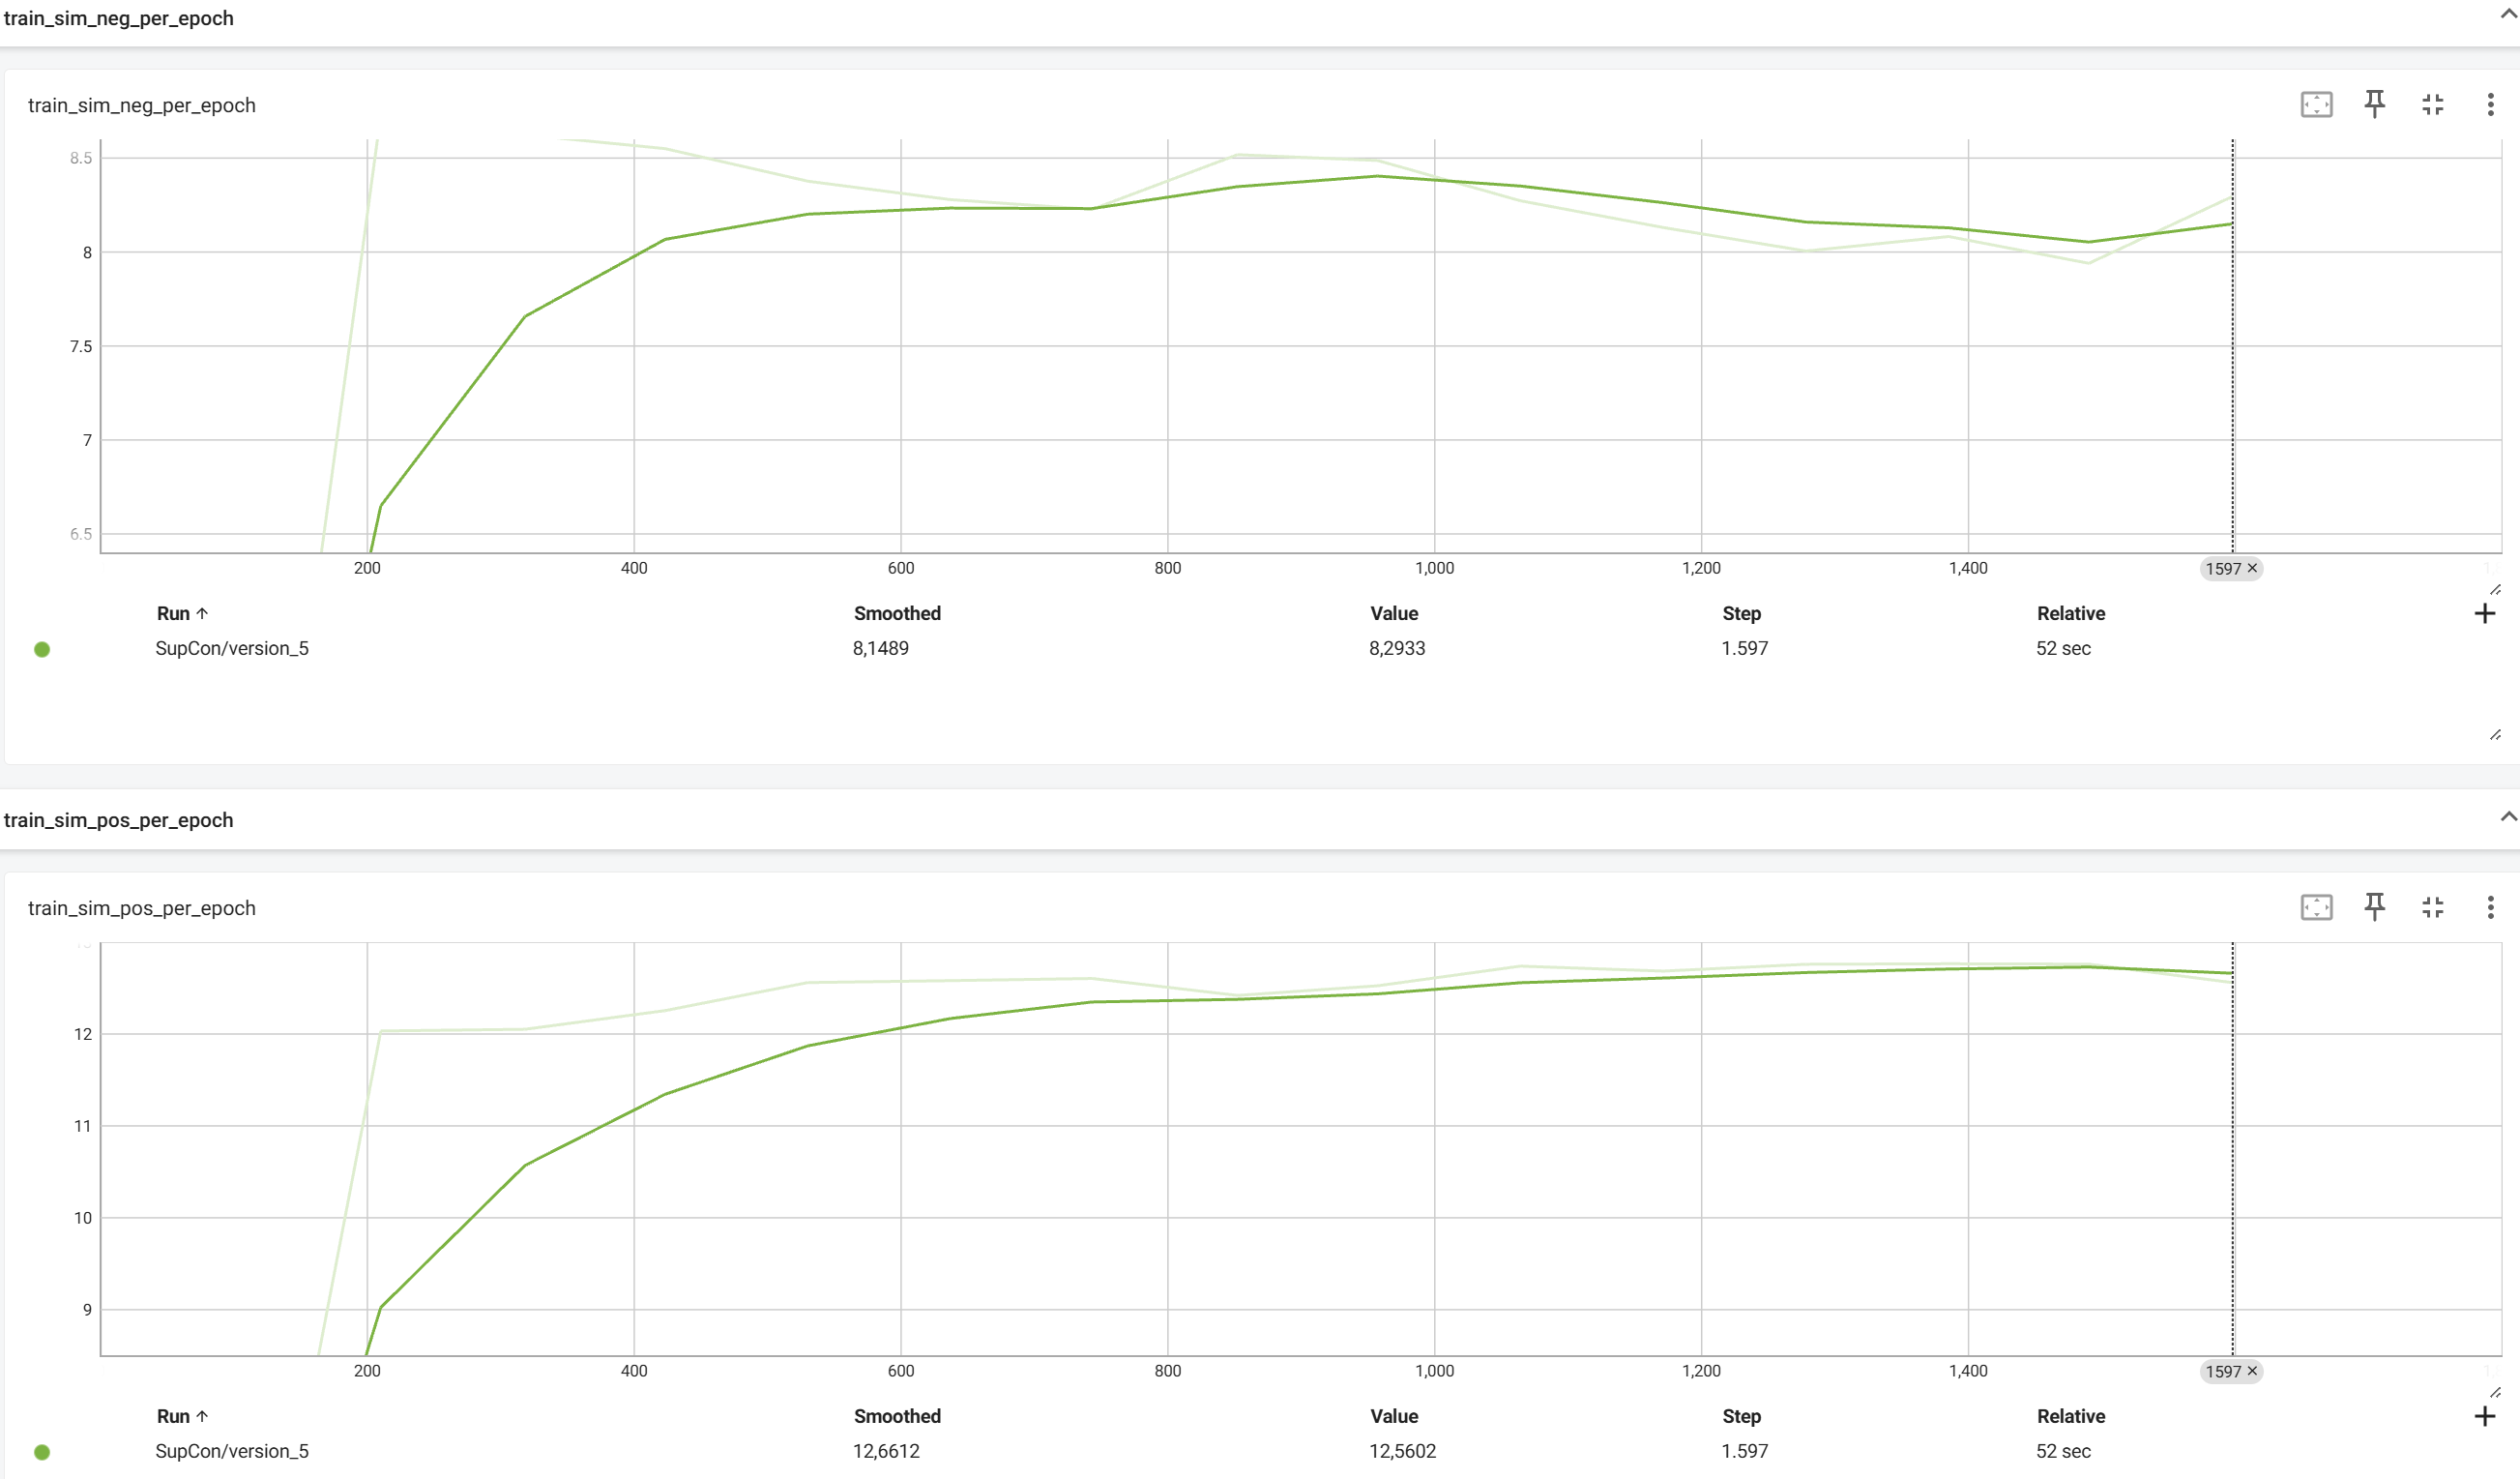

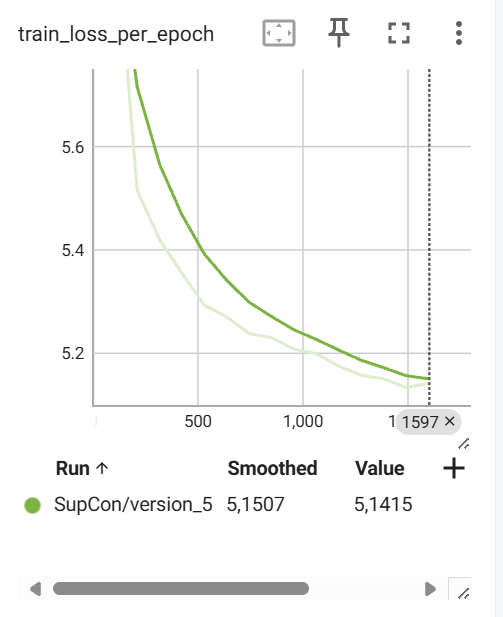

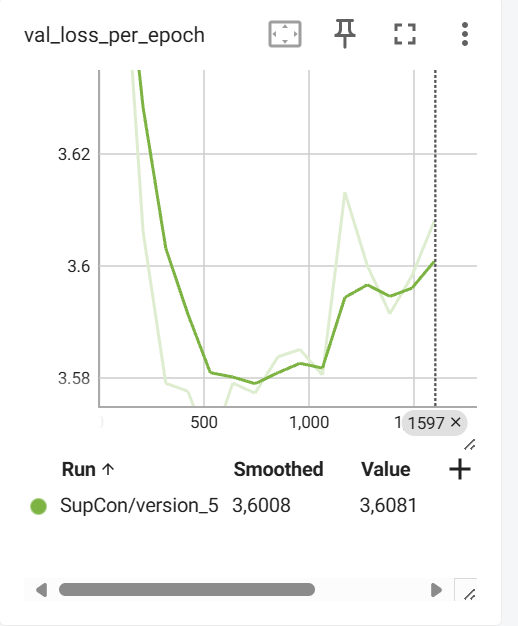
==> Seems to work well

# Later runs

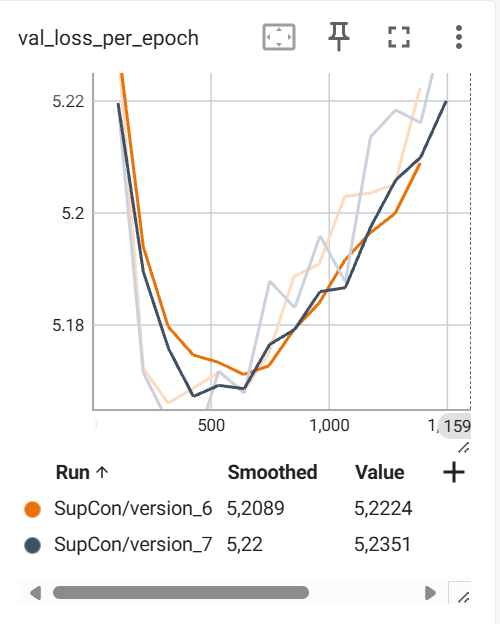

#### The validation loss only decreases for the first few epochs